In [2]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [3]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Building information footprint when the number of RNAPs/repressors exists on a distribution

In [7]:
def simrep_pbound_with_noise(p_seq, r_seq, n_NS, n_p, n_r,
                             p_emat, r_emat, ep_wt, er_wt):

    n_p_new = max(0, int(np.random.normal(n_p, 1000, 1)[0]))
    n_r_new = max(0, int(np.random.normal(n_r, 10, 1)[0]))
    
    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

    z = np.zeros(3)
    z[0] = 1
    z[1] = n_p_new / n_NS * w_p
    z[2] = n_r_new / n_NS * w_r

    return z[1] / np.sum(z)

In [7]:
n_NS = len(genome)
n_p = 3000
n_r = 10
ep_wt = -5
er_wt = -15

stn_with_noise = []
for j in range(50):
    df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])
    
    nbins = 2
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)

    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                            pseudocount=10**(-6))
    total_signal = 0
    region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
    for region in region_params:
        total_signal += np.sum(footprint[(region[0]+115):(region[1]+116)])
    total_noise = np.sum(footprint) - total_signal
    mean_signal = total_signal / (region[1] - region[0] + 1)
    mean_noise = total_noise / (160 - (region[1] - region[0] + 1))
    stn_ratio = mean_signal / mean_noise
    stn_with_noise.append(stn_ratio)

In [8]:
n_NS = len(genome)
n_p = 3000
n_r = 10
ep_wt = -5
er_wt = -15

stn_control = []
for j in range(50):
    df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])
    
    nbins = 2
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)

    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                            pseudocount=10**(-6))
    total_signal = 0
    region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
    for region in region_params:
        total_signal += np.sum(footprint[(region[0]+115):(region[1]+116)])
    total_noise = np.sum(footprint) - total_signal
    mean_signal = total_signal / (region[1] - region[0] + 1)
    mean_noise = total_noise / (160 - (region[1] - region[0] + 1))
    stn_ratio = mean_signal / mean_noise
    stn_control.append(stn_ratio)

In [25]:
n_NS

4641652

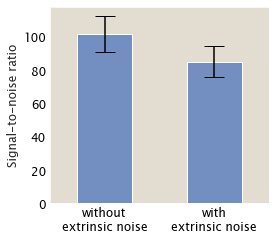

In [24]:
fig, ax = plt.subplots(figsize=(4,3.5))
ax.bar(['without\nextrinsic noise', 'with\nextrinsic noise'],
       [np.mean(stn_control), np.mean(stn_with_noise)],
       yerr=[np.std(stn_control), np.std(stn_with_noise)],
       align='center', color='#738FC1', ecolor='black', capsize=10, width=0.5)
ax.set_ylabel('Signal-to-noise ratio')
ax.set_xlim(-0.5, 1.5)

plt.tight_layout()
plt.savefig('../../figs/extrinsic_noise.png', dpi=300)
plt.show()

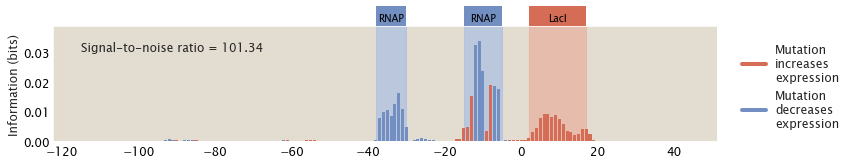

In [16]:
n_NS = len(genome)
n_p = 3000
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../../manuscript/figures/plots/fig14/extrinsic_noise_control.png')

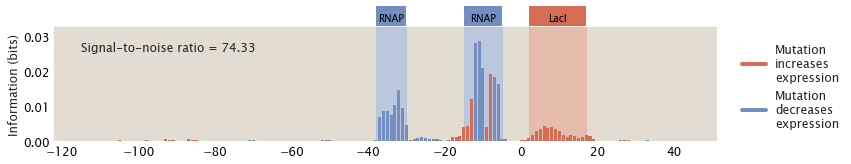

In [17]:
n_NS = len(genome)
n_p = 3000
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../../manuscript/figures/plots/fig14/extrinsic_noise.png')

### Comparing the magnitude of $\Delta p_{\mathrm{bound}}$ due to change in number of RNAPs/repressors and $\Delta p_{\mathrm{bound}}$ due to random mutations

In [15]:
np.mean(rep_emat) * 4 / 3

2.2410320567814286

In [12]:
np.shape(rep_emat)

(21, 4)

In [9]:
len(genome) / n_p

1547.2173333333333

In [10]:
min_energy_change = 0
max_energy_change = 0
for i in range(rnap_emat.shape[0]):
    min_energy_change += min(rnap_emat[i,:])
    max_energy_change += max(rnap_emat[i,:])

In [11]:
min_energy_changea

-7.503926555517484

In [12]:
max_energy_change

15.051976652082343

In [13]:
np.exp(-min_energy_change-5)

12.230423236482252

In [14]:
np.exp(-max_energy_change-5)

1.9567583184774683e-09

In [6]:
## fixing R, varying P

n_NS = len(genome)
n_r = 10
range_n_p = np.arange(1000, 1000000, 1000)

l_pbound1 = []
for n_p in range_n_p:    
    pbound = tregs.simulate.simrep_pbound(rnap_site, rep_site, rnap_emat, rep_emat, n_p, n_r, n_NS,
                                          ep_wt=-5, er_wt=-15)
    l_pbound1.append(pbound)

In [7]:
## fixing P, varying R

n_NS = len(genome)
n_p = 4600
range_n_r = np.arange(1, 100)

l_pbound2 = []
for n_r in range_n_r:    
    pbound = tregs.simulate.simrep_pbound(rnap_site, rep_site, rnap_emat, rep_emat, n_p, n_r, n_NS,
                                          ep_wt=-5, er_wt=-15)
    l_pbound2.append(pbound)

In [8]:
lac_mutants = np.unique(tregs.wgregseq.mutations_rand(promoter, rate=0.1, num_mutants=10000, number_fixed=True))

rnap_site_start, rnap_site_end = tregs.seq_utils.find_binding_site(promoter, rnap_site)
rep_site_start, rep_site_end = tregs.seq_utils.find_binding_site(promoter, rep_site)

l_mut = []
for mut in lac_mutants:
    rv = {}
    rv['seq'] = mut
    rnap_site_mut = mut[rnap_site_start:rnap_site_end].upper()
    rep_site_mut = mut[rep_site_start:rep_site_end].upper()
    
    n_p = 4600
    n_r = 10
    rv['e_rnap'] = tregs.simulate.get_d_energy(rnap_site_mut, rnap_emat, e_wt=-5)
    rv['e_rep'] = tregs.simulate.get_d_energy(rep_site_mut, rep_emat, e_wt=-15)
    rv['pbound'] = tregs.simulate.simrep_pbound(rnap_site_mut, rep_site_mut, rnap_emat, rep_emat, n_p, n_r, n_NS,
                                                  ep_wt=-5, er_wt=-15)
    l_mut.append(rv)

df_mut = pd.DataFrame.from_records(l_mut)

Note:

For simple repression, the expression for probabiltiy of binding can be written as
$$
\begin{align}
    p_{\mathrm{bound}} &= \frac{\frac{P}{N_{NS}} \cdot e^{- \beta \Delta \varepsilon_{p}}}{1 + \frac{P}{N_{NS}} \cdot e^{- \beta \Delta \varepsilon_{p}} + \frac{R}{N_{NS}} \cdot e^{- \beta \Delta \varepsilon_{r}}} \\
        &= \frac{P \cdot e^{- \beta \Delta \varepsilon_{p}}}{N_{NS} + P \cdot e^{- \beta \Delta \varepsilon_{p}} + R \cdot e^{- \beta \Delta \varepsilon_{r}}}.
\end{align}
$$

Here $P = \mathrm{few} \cdot 10^3$, $e^{-\beta \Delta \varepsilon_p} = e^5 \approx 150$, and $N_{NS} \approx \mathrm{few} \cdot 10^6$. Therefore $P \cdot e^{-\beta \Delta \varepsilon_p} \ll N_{NS}$. This means that we can re-write the probability of binding as
$$
    p_{\mathrm{bound}} = \frac{P \cdot e^{- \beta \Delta \varepsilon_{p}}}{N_{NS} + R \cdot e^{- \beta \Delta \varepsilon_{r}}},
$$
therefore $p_\mathrm{bound}$ is linearly related to $P$.

On the other hand, $R = \mathrm{few} \cdot 10$, $e^{-\beta \Delta \varepsilon_r} = e^{15} \approx \mathrm{few} \cdot 10^6$. Therefore $R \cdot e^{-\beta \Delta \varepsilon_r} \gg N_{NS}$. This means that we can re-write the probability of binding as
$$
    p_{\mathrm{bound}} = \frac{1}{1 + R \cdot e^{- \beta \Delta \varepsilon_{r}}},
$$
therefore $p_\mathrm{bound}$ is linearly related to $R^{-1}$.

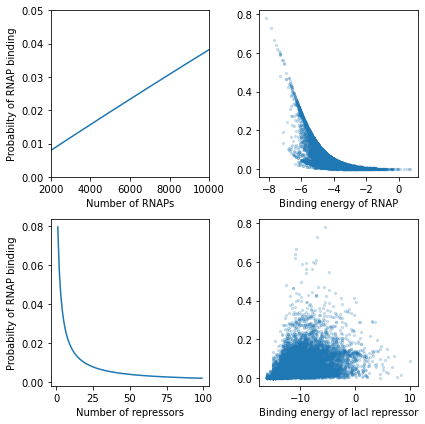

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(range_n_p, l_pbound1)
ax1.set_xlim(2000, 10000)
ax1.set_ylim(0, 0.05)
ax1.set_xlabel('Number of RNAPs')
ax1.set_ylabel('Probabilty of RNAP binding')

ax2.scatter(df_mut.e_rnap, df_mut.pbound, alpha=0.2, s=5)
ax2.set_xlabel('Binding energy of RNAP')

ax3.plot(range_n_r, l_pbound2)
ax3.set_xlabel('Number of repressors')
ax3.set_ylabel('Probabilty of RNAP binding')

ax4.scatter(df_mut.e_rep, df_mut.pbound, alpha=0.2, s=5)
ax4.set_xlabel('Binding energy of lacI repressor')

plt.tight_layout()
plt.show()